In [ ]:
!pip install scikit-image

In [ ]:
!pip install kaggle

In [ ]:
pip install tensorflow-datasets

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.OBO8UA_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.OBO8UA_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.OBO8UA_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
{Split('train'): <SplitInfo num_examples=1020, num_shards=1>, Split('test'): <SplitInfo num_examples=6149, num_shards=2>, Split('validation'): <SplitInfo num_examples=1020, num_shards=1>}
Train shape: (1020, 128, 128, 3)
Valid shape: (1020, 128, 128, 3)
Test shape:  (6149, 128, 128, 3)
conv1 shape: (None, 128, 128, 23)
after SAM conv1 shape: (None, 128, 128, 23)
conv2 shape: (None, 128, 128, 23)
pool1 shape: (None, 64, 64, 23)
conv3 shape: (None, 64, 64, 45)
SAM conv3 shape: (None, 64, 64, 45)
conv4 shape: (None, 64, 64, 45)
pool2 shape: (None, 32, 32, 45)
conv5 shape: (None, 32, 32, 90)
SAM conv5 shape: (None, 32, 32, 90)
conv6 shape: (None, 32, 32, 90)
flatten shape: (None, 92160)
encoding shape: (None, 90)
dense2 shape: (None, 192)
reshape shape: (None, 8, 8, 3)
upsample2 shape: (None, 32, 32, 3)
conv11 shape: (None, 32, 32, 90)
conv12 shape:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step


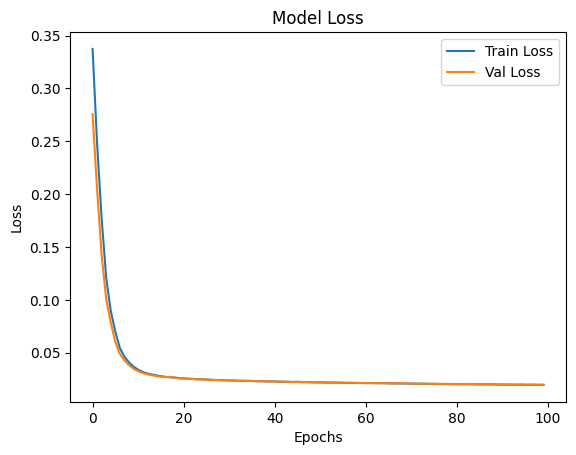

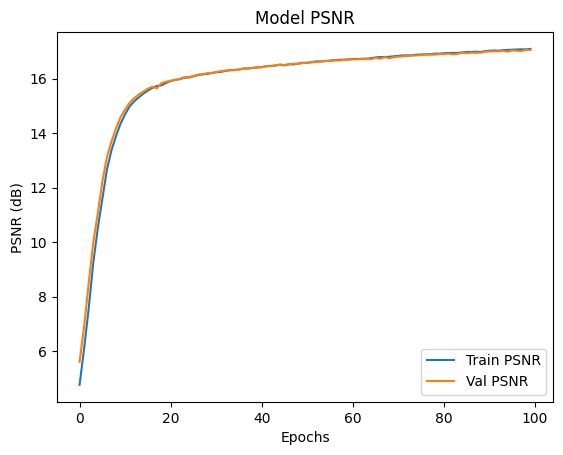

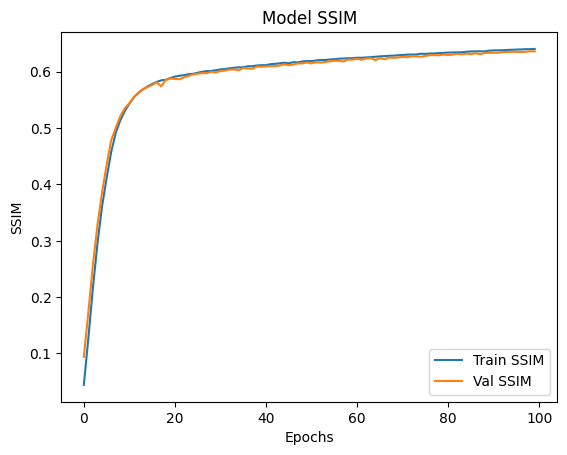

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

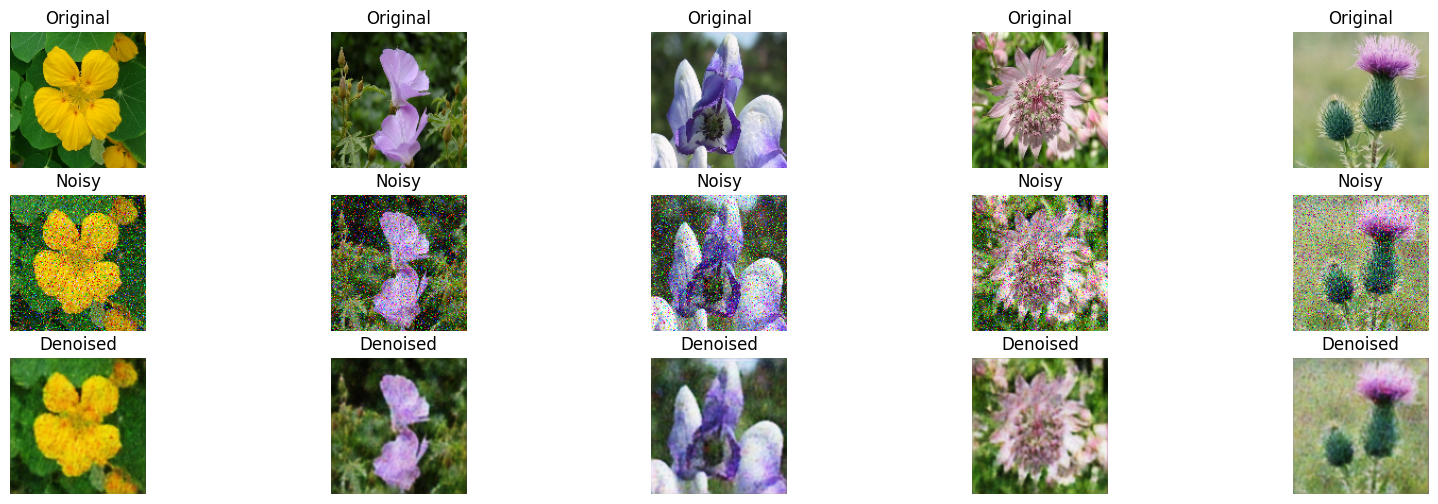

Training and visualization complete.


In [ ]:
# tcnn-SAM_denoising:
# TensorFlow version: 2.17.0

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import PIL, os, random, skimage.util, csv
import tensorflow.keras.backend as K
from google.colab import files
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, AveragePooling2D, UpSampling2D, Reshape, Flatten, Input, Add, Multiply, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import tensorflow_datasets as tfds

dataset, info = tfds.load(
    "oxford_flowers102",
    with_info=True,
    as_supervised=True
)
print(info.splits)

def ds_to_numpy(dataset):
    images, labels = [], []
    for img, lbl in dataset:
        images.append(img.numpy())
        labels.append(lbl.numpy())
    return np.array(images), np.array(labels)

def preprocess(image, label):
    # Resize to 128×128
    image = tf.image.resize(image, [128, 128])
    # Convert [0,255] → [0,1]
    image = tf.cast(image, tf.float32) / 255.0
    # Then [0,1] → [-1,1]
    image = (image * 2.0) - 1.0
    return image, label

#Salt & Pepper, Gaussian Noises
# Function to add noise to images
def add_noise(images, noise_factor=0.2, salt_pepper_amount=0.1):
    noisy_images = []
    for img in images:
        # Add salt & pepper noise
        img_sp = skimage.util.random_noise(img, mode='s&p', amount=salt_pepper_amount)

        # Add Gaussian noise
        img_noisy = img_sp + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
        img_noisy = np.clip(img_noisy, -1.0, 1.0)  # Ensure values are in the valid range [-1, 1]

        noisy_images.append(img_noisy)

    return np.array(noisy_images)

def PSNR(y_true, y_pred):
    max_pixel = 1.0  # Since the images are normalized to the range [-1, 1]
    return 10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true)))) / K.log(10.0)

def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=2.0))

# Define the Spatial Attention Module (SAM)
def spatial_attention(input_feature):
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_feature)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    return Multiply()([input_feature, attention])

splits, info = tfds.load(
    'oxford_flowers102',
    split=['train','test','validation'],
    as_supervised=True,
    with_info=True
)
train_ds, test_ds, val_ds = splits

# Apply to each split
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds  = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# If you only need images, do:
(x_train, _), (x_valid, _), (x_test, _) = (
    ds_to_numpy(train_ds),
    ds_to_numpy(val_ds),
    ds_to_numpy(test_ds)
)

# Convert each split to NumPy
(x_train, y_train) = ds_to_numpy(train_ds)
(x_test, y_test)   = ds_to_numpy(test_ds)
(x_valid, y_valid) = ds_to_numpy(val_ds)

print("Train shape:", x_train.shape)  # e.g. (1020, 128, 128, 3)
print("Valid shape:", x_valid.shape)  # e.g. (1020, 128, 128, 3)
print("Test shape: ", x_test.shape)   # e.g. (6149, 128, 128, 3)

encoding_size = 90
perturbation_max = 40
image_shape = (128,128,3)

model_input = Input(shape=image_shape)

# Encoder
conv1 = Conv2D(23, 3, padding='same', activation='relu')(model_input)
print("conv1 shape:", conv1.shape)
conv1 = spatial_attention(conv1)  # Apply SAM here
print("after SAM conv1 shape:", conv1.shape)

conv2 = Conv2D(23, 3, padding='same', activation='relu')(conv1)
print("conv2 shape:", conv2.shape)
pool1 = AveragePooling2D(2, 2)(conv2)
print("pool1 shape:", pool1.shape)

conv3 = Conv2D(45, 3, padding='same', activation='relu')(pool1)
print("conv3 shape:", conv3.shape)
conv3 = spatial_attention(conv3)  # Apply SAM here
print("SAM conv3 shape:", conv3.shape)

conv4 = Conv2D(45, 3, padding='same', activation='relu')(conv3)
print("conv4 shape:", conv4.shape)
pool2 = AveragePooling2D(2, 2)(conv4)
print("pool2 shape:", pool2.shape)

conv5 = Conv2D(90, 3, padding='same', activation='relu')(pool2)
print("conv5 shape:", conv5.shape)
conv5 = spatial_attention(conv5)  # Apply SAM here
print("SAM conv5 shape:", conv5.shape)

conv6 = Conv2D(90, 3, padding='same', activation='relu')(conv5)
print("conv6 shape:", conv6.shape)

# Decoder
flatten = Flatten()(conv6)
print("flatten shape:", flatten.shape)
encoding = Dense(encoding_size, activation='relu')(flatten)
print("encoding shape:", encoding.shape)
dense2 = Dense(192, activation='relu')(encoding)
print("dense2 shape:", dense2.shape)
reshape = Reshape((8, 8, 3))(dense2)
print("reshape shape:", reshape.shape)

upsample2 = UpSampling2D(size=(4, 4))(reshape)
print("upsample2 shape:", upsample2.shape)
conv11 = Conv2D(90, 3, padding='same', activation='relu')(upsample2)
print("conv11 shape:", conv11.shape)
conv12 = Conv2D(90, 3, padding='same', activation='relu')(conv11)
print("conv12 shape:", conv12.shape)

add1 = Add()([conv12, conv6])
print("add1 shape:", add1.shape)

upsample3 = UpSampling2D(size=(4, 4))(add1)
print("upsample3 shape:", upsample3.shape)
conv13 = Conv2D(45, 3, padding='same', activation='relu')(upsample3)
print("conv13 shape:", conv13.shape)
conv13 = spatial_attention(conv13)  # Apply SAM here
print("conv13 shape:", conv13.shape)

conv14 = Conv2D(45, 3, padding='same', activation='relu')(conv13)
print("conv14 shape:", conv14.shape)
upsample_conv4 = UpSampling2D(size=(2, 2))(conv4)
print("upsample_conv4 shape:", upsample_conv4.shape)
add2 = Add()([conv14, upsample_conv4])
print("add2 shape:", add2.shape)

upsample3 = UpSampling2D(size=(4, 4))(add2)
conv15 = Conv2D(8, 3, padding='same', activation='relu')(add2)
print("conv15 shape:", conv15.shape)
conv16 = Conv2D(3, 3, padding='same', activation='tanh')(conv15)
print("conv16 shape:", conv16.shape)

autoencoder = Model(model_input, conv16)
autoencoder.compile(loss='mse', optimizer=Adam(1e-4), metrics=[PSNR, ssim_metric])

# Ensure the directory exists
checkpoint_dir = 'checkpoint_oxford_flowers'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Define callbacks
checkpoint = ModelCheckpoint('checkpoint_oxford_flowers/best_weights.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

x_train_noisy = add_noise(x_train)
x_valid_noisy = add_noise(x_valid)

#start training
epochs = 100
batch_size = 32
history = autoencoder.fit(
    x_train_noisy, x_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_valid_noisy, x_valid),
    callbacks=[checkpoint, early_stop]
)

history_dict = history.history
num_epochs = len(history_dict['loss'])

csv_filename = f"tcnn-SAM_comparison_plot_{epochs}_epochs.csv"
with open(csv_filename, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch","loss","val_loss","psnr","val_psnr","ssim_metric","val_ssim_metric"])
     # One row per epoch
    for epoch_idx in range(num_epochs):
        row = [
            epoch_idx + 1,
            history_dict['loss'][epoch_idx],
            history_dict['val_loss'][epoch_idx],
            history_dict['psnr'][epoch_idx],
            history_dict['val_psnr'][epoch_idx],
            history_dict['ssim_metric'][epoch_idx],
            history_dict['val_ssim_metric'][epoch_idx]
        ]
        writer.writerow(row)

# Download CSV in Colab
files.download(csv_filename)

# Denoise the images using the autoencoder
denoised_images = autoencoder.predict(x_valid_noisy)

plot_filename_loss = f"tcnn-SAM_loss_plot_{epochs}_epochs.png"
plot_filename_psnr = f"tcnn-SAM_psnr_plot_{epochs}_epochs.png"
plot_filename_ssim = f"tcnn-SAM_ssim_plot_{epochs}_epochs.png"

# Plot training & validation loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(plot_filename_loss)
plt.show()

# Plot PSNR
plt.figure()
plt.plot(history.history['psnr'], label='Train PSNR')
plt.plot(history.history['val_psnr'], label='Val PSNR')
plt.title('Model PSNR')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.savefig(plot_filename_psnr)
plt.show()

#Plot SSIM
plt.figure()
plt.plot(history.history['ssim_metric'], label='Train SSIM')
plt.plot(history.history['val_ssim_metric'], label='Val SSIM')
plt.title('Model SSIM')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()
plt.savefig(plot_filename_ssim)
plt.show()

files.download(plot_filename_loss)
files.download(plot_filename_psnr)
files.download(plot_filename_ssim)

def deprocess(x):
    """Map [-1,1] -> [0,255]."""
    x = (x + 1.0) * 127.5
    return np.clip(x, 0, 255).astype(np.uint8)

def display_images(original, noisy, denoised, n=5):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(deprocess(original[i]))
        plt.title("Original")
        plt.axis("off")

        # Noisy
        ax = plt.subplot(3, n, i+1+n)
        plt.imshow(deprocess(noisy[i]))
        plt.title("Noisy")
        plt.axis("off")

        # Denoised
        ax = plt.subplot(3, n, i+1+2*n)
        plt.imshow(deprocess(denoised[i]))
        plt.title("Denoised")
        plt.axis("off")
    plt.show()

# Visualize the first 5 original, noisy, and denoised images
display_images(x_valid, x_valid_noisy, denoised_images, n=5)

print("Training and visualization complete.")